In [1]:
import numpy as np
import pandas as pd

# --- 1. DEFINE CORE GAME PARAMETERS ---

# Your heuristic multipliers
METRICS = {
    'Revenue': {'multiplier': 700, 'max_value': np.inf},
    'Customer Satisfaction': {'multiplier': 12.5, 'max_value': 100},
    'Reputation': {'multiplier': 0.3, 'max_value': 5},
    'Ethical Decision Making': {'multiplier': 2, 'max_value': 100},
    'Risk-Taking': {'multiplier': 2, 'max_value': 100},
}

# Model for the 4 options available at each decision point
OPTION_SCORES = np.array([0.75, 0.20, -0.10, -0.60]) # Best, Good, Bad, Worst

# Model for player behavior (probability of choosing each option)
PLAYER_CHOICE_PROBS = np.array([0.40, 0.30, 0.20, 0.10])

# Simulation settings
DECISIONS_PER_SCENARIO = 3
NUM_SCENARIOS = 3
NUM_TRIALS = 100_000 # Number of simulated playthroughs

# --- 2. RUN THE MONTE CARLO SIMULATION ---

def run_simulation():
    """
    Simulates players making choices over 3 scenarios and returns their cumulative scores.
    """
    # Create a giant array of random choices for all decisions in all trials
    # Shape: (NUM_TRIALS, NUM_SCENARIOS, DECISIONS_PER_SCENARIO)
    choices = np.random.choice(
        OPTION_SCORES,
        size=(NUM_TRIALS, NUM_SCENARIOS, DECISIONS_PER_SCENARIO),
        p=PLAYER_CHOICE_PROBS
    )

    # Sum the scores for each scenario to get the total kcChange per scenario
    # Shape: (NUM_TRIALS, NUM_SCENARIOS)
    scenario_kc_change = choices.sum(axis=2)

    # Calculate the cumulative kcChange after each scenario
    # Shape: (NUM_TRIALS, NUM_SCENARIOS)
    cumulative_kc_change = np.cumsum(scenario_kc_change, axis=1)

    return cumulative_kc_change

print("Running simulation...")
# This will be a (100000, 3) array where columns are S1, S2, S3 cumulative scores
cumulative_kc_scores = run_simulation()
print(f"Simulation complete with {NUM_TRIALS} trials.")

# --- 3. FIND THE OPTIMAL GOAL FOR EACH METRIC ---

def find_best_goal(metric_name, multiplier, max_val, cumulative_kc_scores):
    """
    Searches for the goal value that best matches the target probabilities.
    """
    # Convert kcChange scores into the metric's actual progress values
    progress_s1 = cumulative_kc_scores[:, 0] * multiplier
    progress_s2 = cumulative_kc_scores[:, 1] * multiplier
    progress_s3 = cumulative_kc_scores[:, 2] * multiplier

    # --- Rule 1: Never win in Scenario 1 ---
    # The goal MUST be higher than the maximum possible score after S1.
    max_s1_score = DECISIONS_PER_SCENARIO * np.max(OPTION_SCORES) * multiplier
    min_goal = max_s1_score + 1e-6 # Add a tiny epsilon to be strictly greater

    # Define a search range for the goal
    # Let's search from the minimum possible goal up to a reasonable maximum
    search_range_max = np.percentile(progress_s3, 95) # A reasonable upper bound
    candidate_goals = np.linspace(min_goal, search_range_max, 500) # Search 500 points

    best_goal = None
    min_error = float('inf')

    for goal in candidate_goals:
        # Check if goal is within the metric's valid range (e.g., Reputation <= 5)
        if goal > max_val:
            continue

        # Calculate win probabilities for this candidate goal
        win_s1 = progress_s1 >= goal
        win_s2 = (progress_s1 < goal) & (progress_s2 >= goal)
        win_s3 = (progress_s2 < goal) & (progress_s3 >= goal)

        prob_win_s1 = np.mean(win_s1)
        # This MUST be zero based on our min_goal calculation, but we check anyway
        if prob_win_s1 > 0:
            continue

        prob_win_exactly_s2 = np.mean(win_s2)
        prob_win_by_s3 = np.mean(win_s2 | win_s3) # Cumulative: win in S2 OR S3

        # Calculate the error (how far are we from the targets?)
        # Target: P(win in S2) = 0.3, P(win by S3) = 0.7
        error = (prob_win_exactly_s2 - 0.30)**2 + (prob_win_by_s3 - 0.70)**2

        if error < min_error:
            min_error = error
            best_goal = goal
            final_probs = (prob_win_exactly_s2, prob_win_by_s3)

    return best_goal, final_probs

# --- 4. CALCULATE AND DISPLAY RESULTS ---

results = []
for name, properties in METRICS.items():
    multiplier = properties['multiplier']
    max_value = properties['max_value']
    
    goal, (p_win2, p_win_by_3) = find_best_goal(
        name, multiplier, max_value, cumulative_kc_scores
    )
    
    results.append({
        "Metric": name,
        "Multiplier": multiplier,
        "Optimal Goal": f"{goal:.2f}",
        "P(Win in S2)": f"{p_win2:.2%}", # Target: 30%
        "P(Win by S3)": f"{p_win_by_3:.2%}"  # Target: 70%
    })

# Display in a clean table
results_df = pd.DataFrame(results)
print("\n--- Optimal Goal Values ---")
print(results_df.to_string(index=False))

Running simulation...
Simulation complete with 100000 trials.

--- Optimal Goal Values ---
                 Metric  Multiplier Optimal Goal P(Win in S2) P(Win by S3)
                Revenue       700.0      1575.00       29.88%       60.61%
  Customer Satisfaction        12.5        28.13       29.88%       60.61%
             Reputation         0.3         0.68       29.88%       60.61%
Ethical Decision Making         2.0         4.50       29.88%       60.61%
            Risk-Taking         2.0         4.50       29.88%       60.61%


In [3]:
import numpy as np
import pandas as pd

# --- 1. DEFINE CORE GAME PARAMETERS ---

# Initial heuristic multipliers (will be used as a starting point for the search)
INITIAL_METRICS = {
    'Revenue': {'multiplier': 700, 'max_value': np.inf},
    'Customer Satisfaction': {'multiplier': 12.5, 'max_value': 100},
    'Reputation': {'multiplier': 0.3, 'max_value': 5},
    'Ethical Decision Making': {'multiplier': 2, 'max_value': 100},
    'Risk-Taking': {'multiplier': 2, 'max_value': 100},
}

# Model for the 4 options available at each decision point
OPTION_SCORES = np.array([0.75, 0.20, -0.10, -0.60]) # Best, Good, Bad, Worst

# Model for player behavior (probability of choosing each option)
PLAYER_CHOICE_PROBS = np.array([0.42, 0.35, 0.15, 0.08])

# Simulation & Optimization settings
DECISIONS_PER_SCENARIO = 3
NUM_SCENARIOS = 3
NUM_TRIALS = 100_000  # High number for stable results
MULTIPLIER_SEARCH_STEPS = 1000 # How many multipliers to test
GOAL_SEARCH_STEPS = 200     # How many goals to test per multiplier

# Target probabilities
TARGET_P_WIN2 = 0.65
TARGET_P_WIN_BY_3 = 0.85

# --- 2. RUN THE MONTE CARLO SIMULATION (ONCE) ---

def run_simulation():
    """Simulates players making choices and returns their cumulative kcChange scores."""
    print("Running core simulation to generate player score distributions...")
    choices = np.random.choice(
        OPTION_SCORES,
        size=(NUM_TRIALS, NUM_SCENARIOS, DECISIONS_PER_SCENARIO),
        p=PLAYER_CHOICE_PROBS
    )
    scenario_kc_change = choices.sum(axis=2)
    cumulative_kc_change = np.cumsum(scenario_kc_change, axis=1)
    print(f"Simulation complete with {NUM_TRIALS} trials.\n")
    return cumulative_kc_change

# This raw score data is the foundation for all optimizations
CUMULATIVE_KC_SCORES = run_simulation()

# --- 3. CREATE THE TWO-LEVEL OPTIMIZATION FUNCTION ---

def find_best_params(metric_name, initial_multiplier, max_val, cumulative_kc_scores):
    """
    Searches for the best (multiplier, goal) pair to match target probabilities.
    """
    print(f"--- Optimizing for: {metric_name} ---")
    
    # Define a search range for the multiplier around its initial value
    # e.g., for 700, search from 350 to 1400
    multiplier_range = np.linspace(initial_multiplier * 0.5, initial_multiplier * 5.0, MULTIPLIER_SEARCH_STEPS)
    
    overall_best = {'error': float('inf')}

    # Outer loop: Iterate through candidate multipliers
    for mult in multiplier_range:
        
        # Calculate progress scores for this specific multiplier
        progress_s1 = cumulative_kc_scores[:, 0] * mult
        progress_s2 = cumulative_kc_scores[:, 1] * mult
        progress_s3 = cumulative_kc_scores[:, 2] * mult

        # Rule 1: Never win in S1. The goal must be higher than the max possible S1 score.
        max_s1_score = DECISIONS_PER_SCENARIO * np.max(OPTION_SCORES) * mult
        min_goal = max_s1_score + 1e-6

        # If even the minimum possible goal is outside the metric's bounds, this multiplier is invalid.
        if min_goal > max_val:
            continue

        # Define a search range for the goal for this multiplier
        search_range_max = np.percentile(progress_s3, 95)
        candidate_goals = np.linspace(min_goal, min(search_range_max, max_val), GOAL_SEARCH_STEPS)
        
        # Inner loop: Find the best goal for the current multiplier
        for goal in candidate_goals:
            win_s1 = progress_s1 >= goal
            win_s2 = (progress_s1 < goal) & (progress_s2 >= goal)
            win_s3 = (progress_s2 < goal) & (progress_s3 >= goal)

            # This must be 0 based on our min_goal rule
            if np.any(win_s1): continue

            prob_win_exactly_s2 = np.mean(win_s2)
            prob_win_by_s3 = np.mean(win_s2 | win_s3)

            # Weighted error function to prioritize hitting targets
            error = (prob_win_exactly_s2 - TARGET_P_WIN2)**2 + (prob_win_by_s3 - TARGET_P_WIN_BY_3)**2

            if error < overall_best['error']:
                overall_best['error'] = error
                overall_best['multiplier'] = mult
                overall_best['goal'] = goal
                overall_best['p_win2'] = prob_win_exactly_s2
                overall_best['p_win_by_3'] = prob_win_by_s3

    print(f"Optimization complete for {metric_name}.")
    return overall_best


# --- 4. CALCULATE AND DISPLAY RESULTS ---

final_results = []
for name, properties in INITIAL_METRICS.items():
    best_params = find_best_params(
        name,
        properties['multiplier'],
        properties['max_value'],
        CUMULATIVE_KC_SCORES
    )
    
    final_results.append({
        "Metric": name,
        "Optimal Multiplier": f"{best_params['multiplier']:.2f}",
        "Optimal Goal": f"{best_params['goal']:.2f}",
        "P(Win in S2)": f"{best_params['p_win2']:.2%}",
        "P(Win by S3)": f"{best_params['p_win_by_3']:.2%}"
    })

# Display in a clean table
results_df = pd.DataFrame(final_results)
print("\n\n--- Final Optimized Parameters ---")
print(results_df.to_string(index=False))

Running core simulation to generate player score distributions...
Simulation complete with 100000 trials.

--- Optimizing for: Revenue ---
Optimization complete for Revenue.
--- Optimizing for: Customer Satisfaction ---
Optimization complete for Customer Satisfaction.
--- Optimizing for: Reputation ---
Optimization complete for Reputation.
--- Optimizing for: Ethical Decision Making ---
Optimization complete for Ethical Decision Making.
--- Optimizing for: Risk-Taking ---
Optimization complete for Risk-Taking.


--- Final Optimized Parameters ---
                 Metric Optimal Multiplier Optimal Goal P(Win in S2) P(Win by S3)
                Revenue             350.00       805.79       33.87%       69.50%
  Customer Satisfaction               6.25        14.39       33.87%       69.50%
             Reputation               0.15         0.35       33.87%       69.50%
Ethical Decision Making               1.00         2.30       33.87%       69.50%
            Risk-Taking              

Running core simulation to generate player score distributions...
Simulation complete with 100000 trials.



C:\Users\eduar\AppData\Local\Temp\ipykernel_24152\3170328400.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=probs, palette="viridis")


Generating Visual 1: Player Choice Probabilities...
Generating Visual 2: Cumulative Score Distributions...
--- Optimizing for: Revenue ---
Optimization complete for Revenue.
Generating Visual 3: 'Knob' Effects...
Generating Visual 4: Optimization Heatmap...
--- Optimizing for: Customer Satisfaction ---
Optimization complete for Customer Satisfaction.
--- Optimizing for: Reputation ---
Optimization complete for Reputation.
--- Optimizing for: Ethical Decision Making ---
Optimization complete for Ethical Decision Making.
--- Optimizing for: Risk-Taking ---
Optimization complete for Risk-Taking.


--- Final Optimized Parameters (Visual 5: The Results Table) ---
                 Metric Optimal Multiplier Optimal Goal Result P(Win in S2) Target P(Win in S2) Result P(Win by S3) Target P(Win by S3)
                Revenue             350.00       799.52              38.74%              65.00%              72.08%              85.00%
  Customer Satisfaction               6.25        14.28      

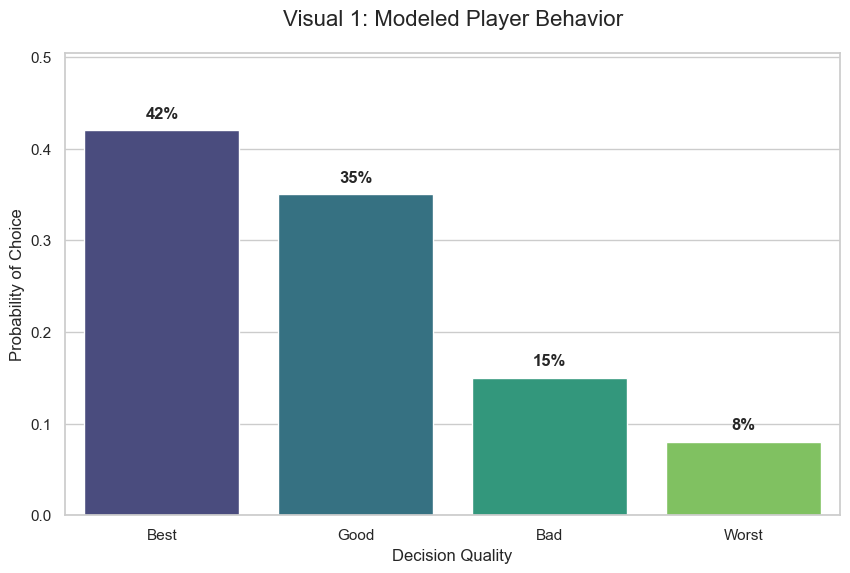

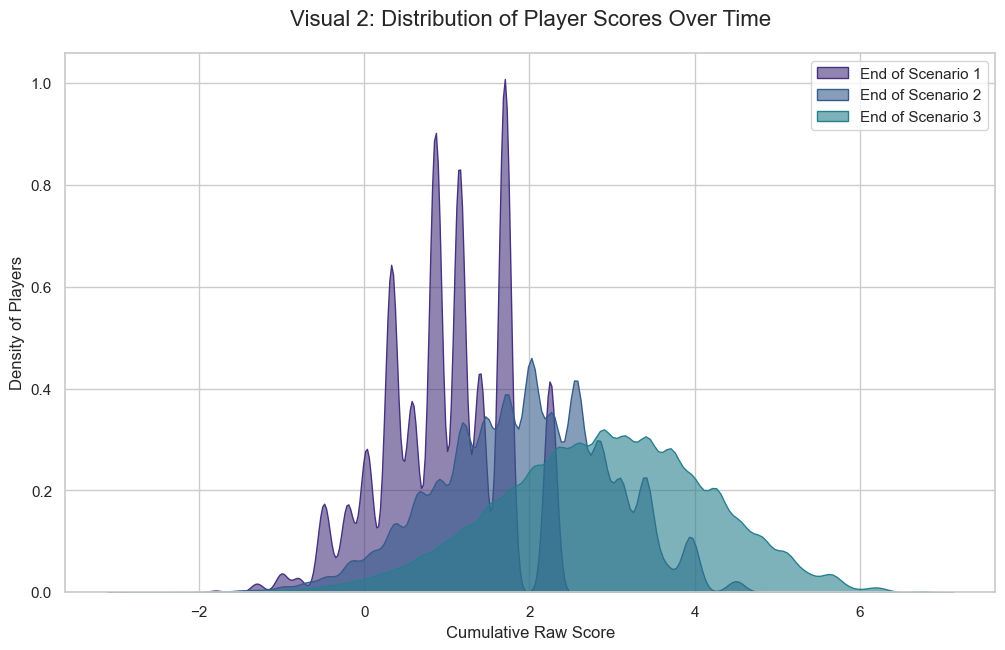

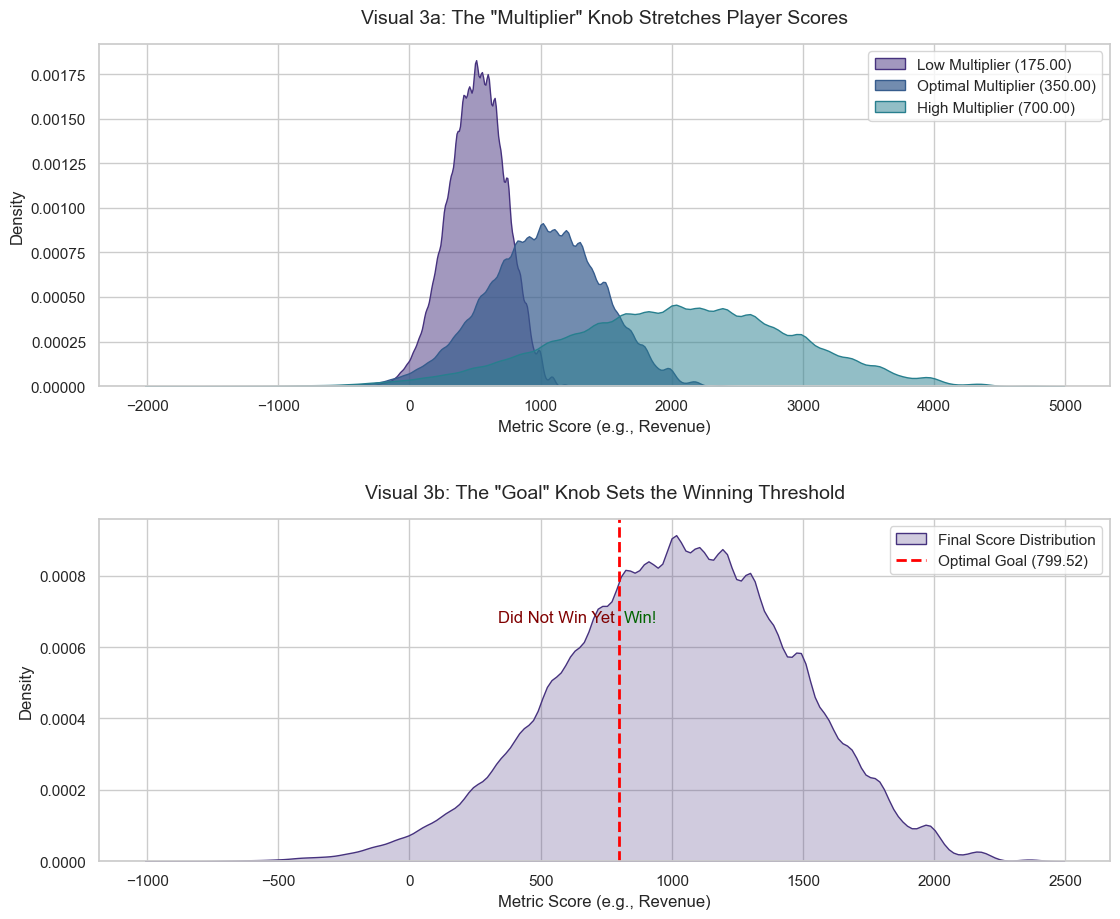

d:\anaconda3\envs\ipl\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


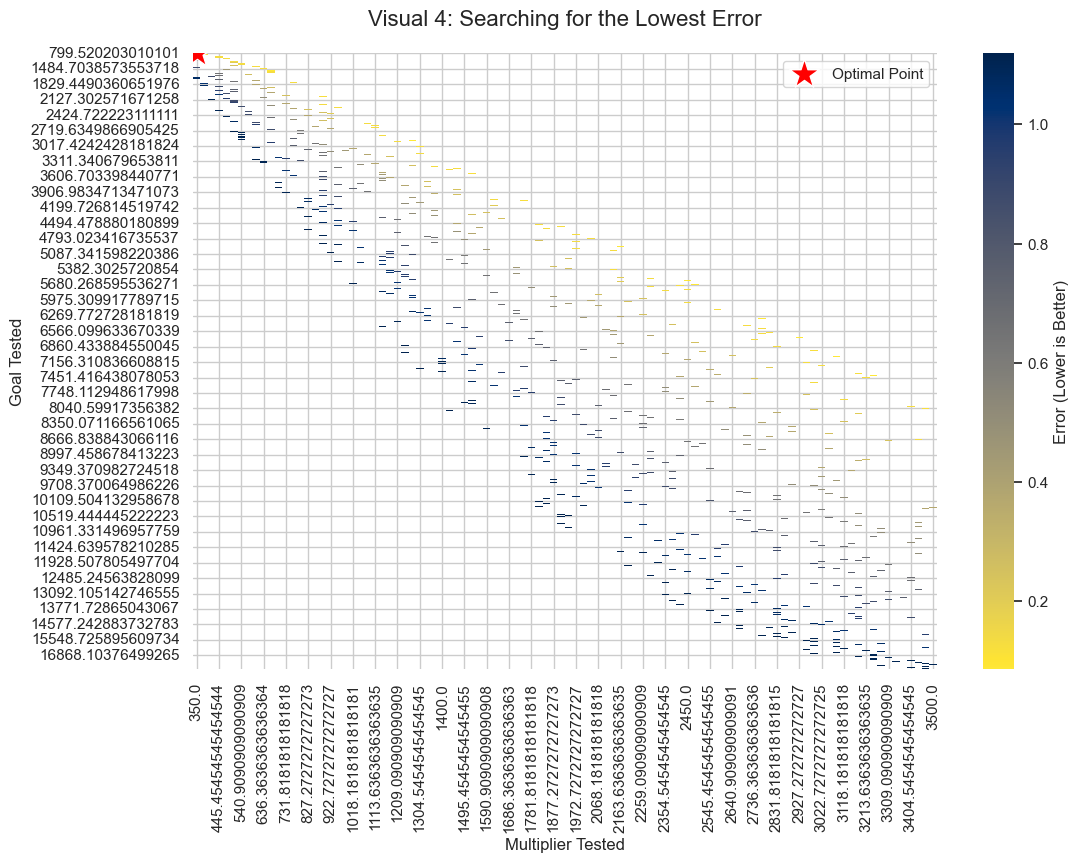

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. DEFINE CORE GAME PARAMETERS ---

# Initial heuristic multipliers (will be used as a starting point for the search)
INITIAL_METRICS = {
    'Revenue': {'multiplier': 700, 'max_value': np.inf},
    'Customer Satisfaction': {'multiplier': 12.5, 'max_value': 100},
    'Reputation': {'multiplier': 0.3, 'max_value': 5},
    'Ethical Decision Making': {'multiplier': 2, 'max_value': 100},
    'Risk-Taking': {'multiplier': 2, 'max_value': 100},
}

# Model for the 4 options available at each decision point
OPTION_SCORES = np.array([0.75, 0.20, -0.10, -0.60]) # Best, Good, Bad, Worst
OPTION_LABELS = ['Best', 'Good', 'Bad', 'Worst']

# Model for player behavior (probability of choosing each option)
PLAYER_CHOICE_PROBS = np.array([0.42, 0.35, 0.15, 0.08])

# Simulation & Optimization settings
DECISIONS_PER_SCENARIO = 3
NUM_SCENARIOS = 3
NUM_TRIALS = 100_000  # High number for stable results
MULTIPLIER_SEARCH_STEPS = 100 # Reduced for faster visualization generation
GOAL_SEARCH_STEPS = 100     # Reduced for faster visualization generation

# Target probabilities (UPDATED AS PER YOUR REQUEST)
TARGET_P_WIN2 = 0.65
TARGET_P_WIN_BY_3 = 0.85

# --- VISUALIZATION SETUP ---
sns.set_theme(style="whitegrid", palette="viridis")

# --- VISUALIZATION FUNCTIONS ---

def plot_player_choice_probs(probs, labels):
    """Visualizes the assumed player choice probabilities (Slide 2)."""
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=labels, y=probs, palette="viridis")
    ax.set_title('Visual 1: Modeled Player Behavior', fontsize=16, pad=20)
    ax.set_xlabel('Decision Quality', fontsize=12)
    ax.set_ylabel('Probability of Choice', fontsize=12)
    for index, value in enumerate(probs):
        plt.text(index, value + 0.01, f'{value:.0%}', ha='center', va='bottom', fontsize=12, weight='bold')
    plt.ylim(0, max(probs) * 1.2)
    print("Generating Visual 1: Player Choice Probabilities...")

def plot_cumulative_score_distributions(scores):
    """Visualizes the distribution of player scores over time (Slide 3)."""
    plt.figure(figsize=(12, 7))
    sns.kdeplot(scores[:, 0], fill=True, alpha=0.6, label='End of Scenario 1')
    sns.kdeplot(scores[:, 1], fill=True, alpha=0.6, label='End of Scenario 2')
    sns.kdeplot(scores[:, 2], fill=True, alpha=0.6, label='End of Scenario 3')
    plt.title('Visual 2: Distribution of Player Scores Over Time', fontsize=16, pad=20)
    plt.xlabel("Cumulative Raw Score", fontsize=12)
    plt.ylabel("Density of Players", fontsize=12)
    plt.legend()
    print("Generating Visual 2: Cumulative Score Distributions...")

def plot_knob_effects(scores_s3, optimal_goal, optimal_multiplier):
    """Visualizes the effect of the Multiplier and Goal 'knobs' (Slide 4)."""
    # Part 1: The Multiplier Effect
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    low_mult = optimal_multiplier * 0.5
    high_mult = optimal_multiplier * 2.0
    
    sns.kdeplot(scores_s3 * low_mult, label=f'Low Multiplier ({low_mult:.2f})', fill=True, alpha=0.5)
    sns.kdeplot(scores_s3 * optimal_multiplier, label=f'Optimal Multiplier ({optimal_multiplier:.2f})', fill=True, alpha=0.7)
    sns.kdeplot(scores_s3 * high_mult, label=f'High Multiplier ({high_mult:.2f})', fill=True, alpha=0.5)
    
    plt.title('Visual 3a: The "Multiplier" Knob Stretches Player Scores', fontsize=14, pad=15)
    plt.xlabel('Metric Score (e.g., Revenue)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()

    # Part 2: The Goal Effect
    plt.subplot(2, 1, 2)
    final_scores = scores_s3 * optimal_multiplier
    sns.kdeplot(final_scores, fill=True, label='Final Score Distribution')
    plt.axvline(x=optimal_goal, color='red', linestyle='--', linewidth=2, label=f'Optimal Goal ({optimal_goal:.2f})')
    
    plt.title('Visual 3b: The "Goal" Knob Sets the Winning Threshold', fontsize=14, pad=15)
    plt.xlabel('Metric Score (e.g., Revenue)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    # Add text annotations
    ylim = plt.gca().get_ylim()
    plt.text(optimal_goal * 0.98, ylim[1] * 0.7, 'Did Not Win Yet', ha='right', fontsize=12, color='maroon')
    plt.text(optimal_goal * 1.02, ylim[1] * 0.7, 'Win!', ha='left', fontsize=12, color='darkgreen')
    
    plt.legend()
    plt.tight_layout(pad=3.0)
    print("Generating Visual 3: 'Knob' Effects...")

def plot_optimization_heatmap(heatmap_data, best_params):
    """Visualizes the search for the best parameters (Slide 5)."""
    if heatmap_data.empty:
        print("Could not generate heatmap: no valid (multiplier, goal) pairs found.")
        return
        
    # Pivot the data to create a 2D grid of errors
    error_pivot = heatmap_data.pivot(index='goal', columns='multiplier', values='error')
    
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(error_pivot, cmap="cividis_r", cbar_kws={'label': 'Error (Lower is Better)'})
    ax.set_title('Visual 4: Searching for the Lowest Error', fontsize=16, pad=20)
    ax.set_xlabel('Multiplier Tested', fontsize=12)
    ax.set_ylabel('Goal Tested', fontsize=12)
    
    # Find the integer index locations for the best parameters to plot a marker
    best_mult_loc = np.argmin(np.abs(error_pivot.columns - best_params['multiplier']))
    best_goal_loc = np.argmin(np.abs(error_pivot.index - best_params['goal']))

    plt.scatter(best_mult_loc + 0.5, best_goal_loc + 0.5, marker='*', s=500, color='red', edgecolor='white', label='Optimal Point')
    
    plt.legend()
    print("Generating Visual 4: Optimization Heatmap...")


# --- 2. RUN THE MONTE CARLO SIMULATION (ONCE) ---

def run_simulation():
    """Simulates players making choices and returns their cumulative kcChange scores."""
    print("Running core simulation to generate player score distributions...")
    choices = np.random.choice(
        OPTION_SCORES,
        size=(NUM_TRIALS, NUM_SCENARIOS, DECISIONS_PER_SCENARIO),
        p=PLAYER_CHOICE_PROBS
    )
    scenario_kc_change = choices.sum(axis=2)
    cumulative_kc_change = np.cumsum(scenario_kc_change, axis=1)
    print(f"Simulation complete with {NUM_TRIALS} trials.\n")
    return cumulative_kc_change

# --- 3. CREATE THE TWO-LEVEL OPTIMIZATION FUNCTION (MODIFIED FOR VISUALIZATION) ---

def find_best_params(metric_name, initial_multiplier, max_val, cumulative_kc_scores):
    """
    Searches for the best (multiplier, goal) pair and returns data for heatmap.
    """
    print(f"--- Optimizing for: {metric_name} ---")
    
    multiplier_range = np.linspace(initial_multiplier * 0.5, initial_multiplier * 5.0, MULTIPLIER_SEARCH_STEPS)
    
    overall_best = {'error': float('inf')}
    all_results = [] # Store all results for the heatmap

    for mult in multiplier_range:
        progress_s1 = cumulative_kc_scores[:, 0] * mult
        progress_s2 = cumulative_kc_scores[:, 1] * mult
        progress_s3 = cumulative_kc_scores[:, 2] * mult

        max_s1_score = DECISIONS_PER_SCENARIO * np.max(OPTION_SCORES) * mult
        min_goal = max_s1_score + 1e-6
        if min_goal > max_val: continue

        search_range_max = np.percentile(progress_s3, 99) # Use 99th percentile for broader search
        candidate_goals = np.linspace(min_goal, min(search_range_max, max_val), GOAL_SEARCH_STEPS)
        
        for goal in candidate_goals:
            if goal <= min_goal: continue # Ensure goal is valid
            
            win_s2 = (progress_s1 < goal) & (progress_s2 >= goal)
            win_s3 = (progress_s2 < goal) & (progress_s3 >= goal)

            prob_win_exactly_s2 = np.mean(win_s2)
            prob_win_by_s3 = np.mean(win_s2 | win_s3)

            error = (prob_win_exactly_s2 - TARGET_P_WIN2)**2 + (prob_win_by_s3 - TARGET_P_WIN_BY_3)**2

            # Store result for heatmap
            all_results.append({'multiplier': mult, 'goal': goal, 'error': error})

            if error < overall_best['error']:
                overall_best = {
                    'error': error, 'multiplier': mult, 'goal': goal,
                    'p_win2': prob_win_exactly_s2, 'p_win_by_3': prob_win_by_s3
                }

    print(f"Optimization complete for {metric_name}.")
    return overall_best, pd.DataFrame(all_results)


# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # This raw score data is the foundation for all optimizations
    CUMULATIVE_KC_SCORES = run_simulation()

    # --- Generate Core Visuals ---
    plot_player_choice_probs(PLAYER_CHOICE_PROBS, OPTION_LABELS)
    plot_cumulative_score_distributions(CUMULATIVE_KC_SCORES)

    # --- Run Optimization and Generate Metric-Specific Visuals ---
    final_results = []
    
    # We will generate the detailed visuals only for the first metric ('Revenue')
    # as an example for the stakeholders.
    first_metric = True
    
    for name, properties in INITIAL_METRICS.items():
        best_params, heatmap_df = find_best_params(
            name,
            properties['multiplier'],
            properties['max_value'],
            CUMULATIVE_KC_SCORES
        )
        
        if best_params['error'] == float('inf'):
            print(f"\nCould not find a solution for {name}. It might be impossible to meet the targets with the given constraints.")
            continue
            
        # For the first metric, generate the detailed "how it works" plots
        if first_metric:
            plot_knob_effects(CUMULATIVE_KC_SCORES[:, 2], best_params['goal'], best_params['multiplier'])
            plot_optimization_heatmap(heatmap_df, best_params)
            first_metric = False

        final_results.append({
            "Metric": name,
            "Optimal Multiplier": f"{best_params['multiplier']:.2f}",
            "Optimal Goal": f"{best_params['goal']:.2f}",
            "Result P(Win in S2)": f"{best_params['p_win2']:.2%}",
            "Target P(Win in S2)": f"{TARGET_P_WIN2:.2%}",
            "Result P(Win by S3)": f"{best_params['p_win_by_3']:.2%}",
            "Target P(Win by S3)": f"{TARGET_P_WIN_BY_3:.2%}",
        })

    # Display final results in a clean table
    if final_results:
        results_df = pd.DataFrame(final_results)
        print("\n\n--- Final Optimized Parameters (Visual 5: The Results Table) ---")
        print(results_df.to_string(index=False))
    
    # Show all generated plots
    plt.show()

Running core simulation to generate player score distributions...
Simulation complete with 100000 trials.

Generating Visual 1: Player Choice Probabilities...


C:\Users\eduar\AppData\Local\Temp\ipykernel_24152\1371878163.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=probs, palette="viridis")


Generating Visual 2: Cumulative Score Distributions...
--- Optimizing for: Revenue ---
Optimization complete for Revenue. Best error: 0.0828
Generating Visual 3: 'Knob' Effects...
Generating Visual 4: Optimization Heatmap...
--- Optimizing for: Customer Satisfaction ---
Optimization complete for Customer Satisfaction. Best error: 0.0828
--- Optimizing for: Reputation ---
Optimization complete for Reputation. Best error: 0.0828
--- Optimizing for: Ethical Decision Making ---
Optimization complete for Ethical Decision Making. Best error: 0.0828
--- Optimizing for: Risk-Taking ---
Optimization complete for Risk-Taking. Best error: 0.0828


--- Final Optimized Parameters (Visual 5: The Results Table) ---
                 Metric Optimal Multiplier Optimal Goal Result P(Win in S2) Target P(Win in S2) Result P(Win by S3) Target P(Win by S3)
                Revenue             350.00       787.50              39.12%              65.00%              72.43%              85.00%
  Customer Satisfa

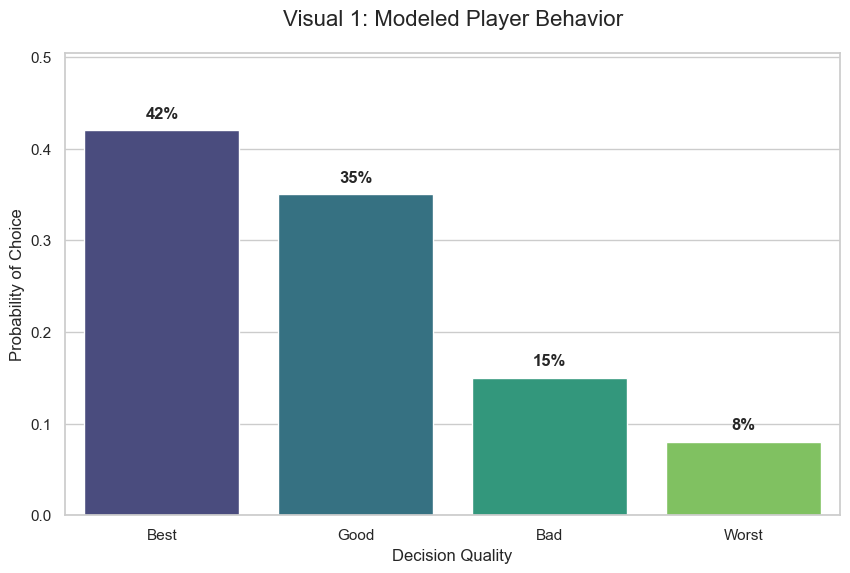

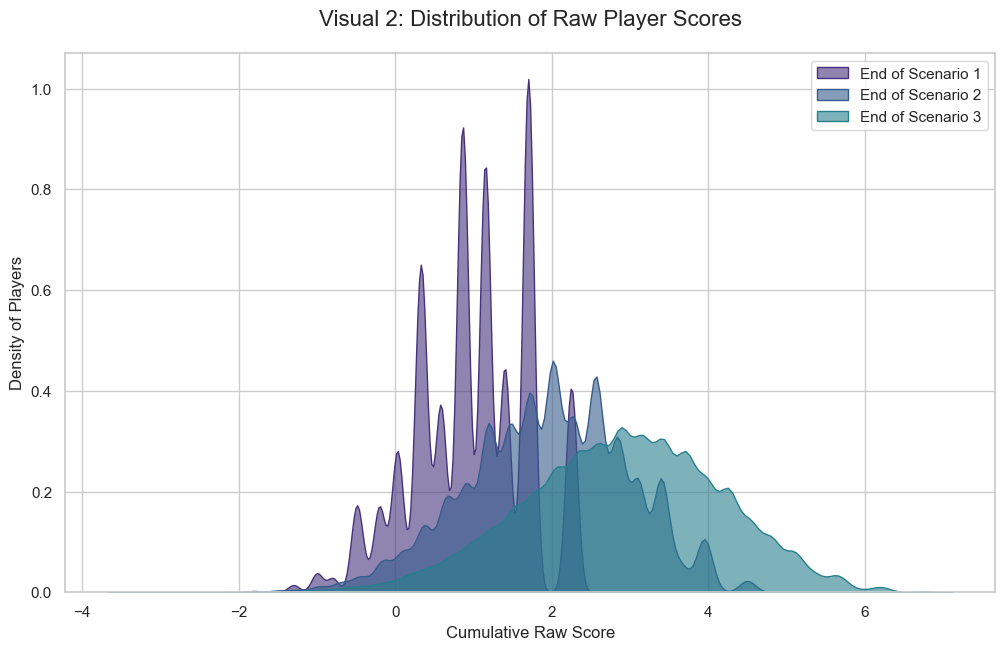

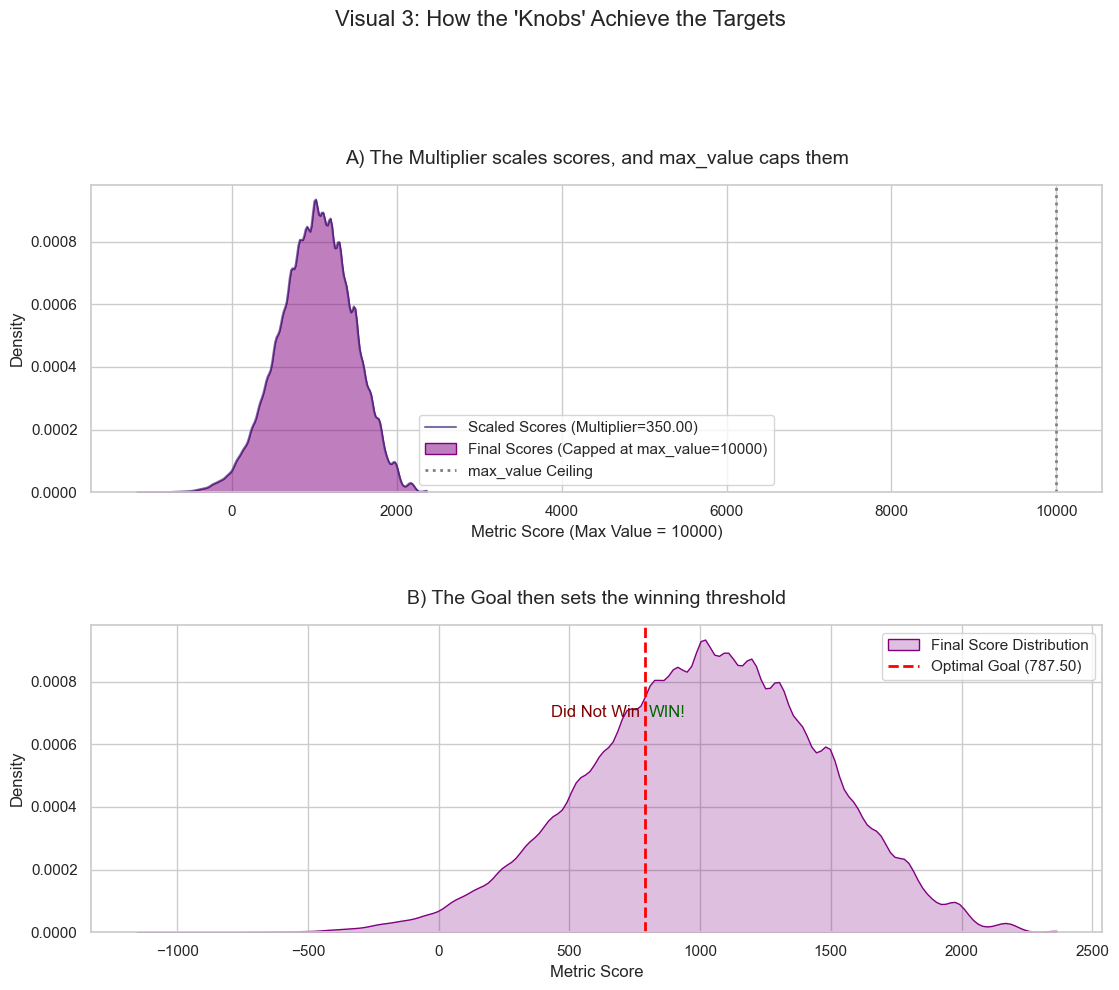

d:\anaconda3\envs\ipl\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


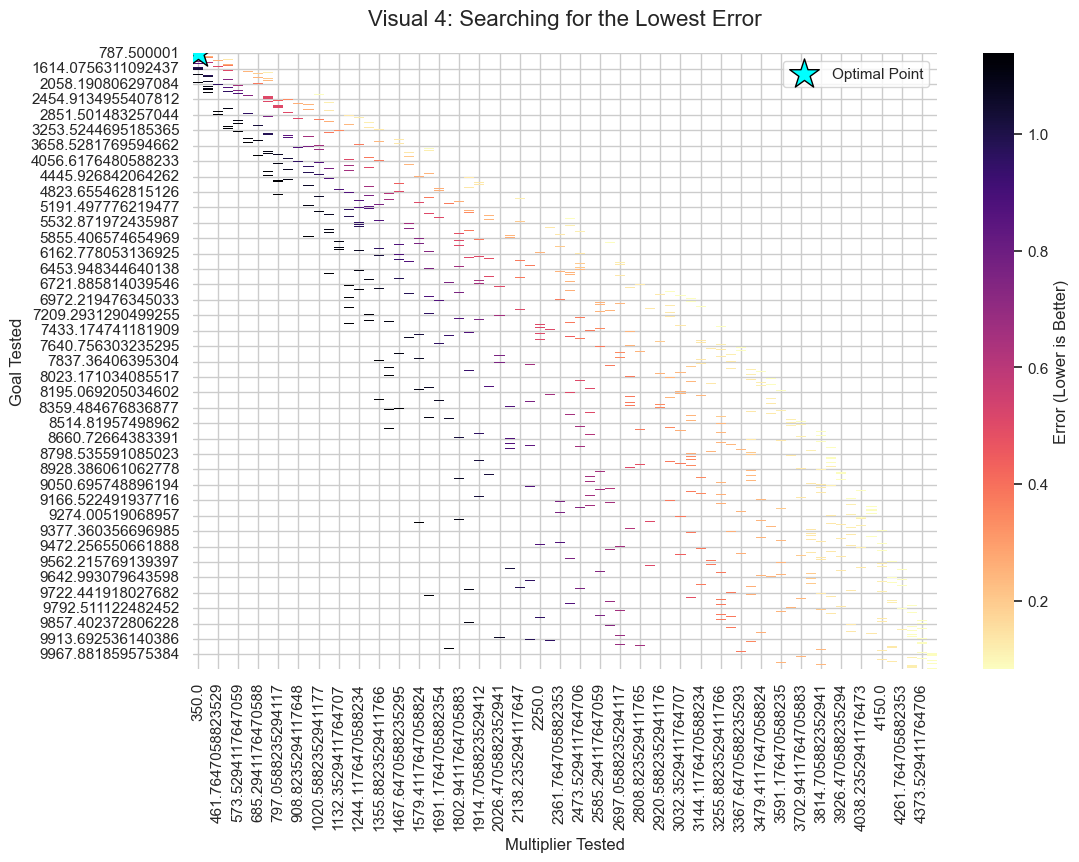

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. DEFINE CORE GAME PARAMETERS ---

INITIAL_METRICS = {
    'Revenue': {'multiplier': 700, 'max_value': 10000, 'search_range': (350, 7000)}, # Explicit search range
    'Customer Satisfaction': {'multiplier': 12.5, 'max_value': 100},
    'Reputation': {'multiplier': 0.3, 'max_value': 5},
    'Ethical Decision Making': {'multiplier': 2, 'max_value': 100},
    'Risk-Taking': {'multiplier': 2, 'max_value': 100},
}

OPTION_SCORES = np.array([0.75, 0.20, -0.10, -0.60])
OPTION_LABELS = ['Best', 'Good', 'Bad', 'Worst']
PLAYER_CHOICE_PROBS = np.array([0.42, 0.35, 0.15, 0.08])

DECISIONS_PER_SCENARIO = 3
NUM_SCENARIOS = 3
NUM_TRIALS = 100_000
MULTIPLIER_SEARCH_STEPS = 120 # Increased steps for a wider search
GOAL_SEARCH_STEPS = 120

# --- UPDATED TARGETS ---
# P(Win in S1) should be 0.
# P(Win in exactly S2) should be 0.65
# P(Win by S3) = P(Win in S2) + P(Win in S3) should be 0.85
TARGET_P_WIN_EXACTLY_S2 = 0.65
TARGET_P_WIN_BY_S3 = 0.85

# --- VISUALIZATION SETUP ---
sns.set_theme(style="whitegrid", palette="viridis")

# (Visualization functions remain the same as the previous version)
def plot_player_choice_probs(probs, labels):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=labels, y=probs, palette="viridis")
    ax.set_title('Visual 1: Modeled Player Behavior', fontsize=16, pad=20)
    ax.set_xlabel('Decision Quality', fontsize=12)
    ax.set_ylabel('Probability of Choice', fontsize=12)
    for index, value in enumerate(probs):
        plt.text(index, value + 0.01, f'{value:.0%}', ha='center', va='bottom', fontsize=12, weight='bold')
    plt.ylim(0, max(probs) * 1.2)
    print("Generating Visual 1: Player Choice Probabilities...")

def plot_cumulative_score_distributions(scores):
    plt.figure(figsize=(12, 7))
    sns.kdeplot(scores[:, 0], fill=True, alpha=0.6, label='End of Scenario 1')
    sns.kdeplot(scores[:, 1], fill=True, alpha=0.6, label='End of Scenario 2')
    sns.kdeplot(scores[:, 2], fill=True, alpha=0.6, label='End of Scenario 3')
    plt.title('Visual 2: Distribution of Raw Player Scores', fontsize=16, pad=20)
    plt.xlabel("Cumulative Raw Score", fontsize=12)
    plt.ylabel("Density of Players", fontsize=12)
    plt.legend()
    print("Generating Visual 2: Cumulative Score Distributions...")

def plot_knob_effects(scores_s3, optimal_goal, optimal_multiplier, max_val):
    plt.figure(figsize=(12, 10))
    plt.suptitle("Visual 3: How the 'Knobs' Achieve the Targets", fontsize=16, y=1.02)
    
    # Part 1: The Multiplier + Max Value Effect
    plt.subplot(2, 1, 1)
    final_scores = scores_s3 * optimal_multiplier
    # Here we cap the scores at the metric's max_value, which is a key part of the logic
    final_scores_capped = np.minimum(final_scores, max_val)
    
    sns.kdeplot(final_scores, label=f'Scaled Scores (Multiplier={optimal_multiplier:.2f})', fill=False, alpha=0.7, cut=0)
    sns.kdeplot(final_scores_capped, label=f'Final Scores (Capped at max_value={max_val})', fill=True, alpha=0.5, color='purple', cut=0)
    
    plt.title('A) The Multiplier scales scores, and max_value caps them', fontsize=14, pad=15)
    plt.xlabel(f'Metric Score (Max Value = {max_val})', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    if max_val != np.inf:
        plt.axvline(x=max_val, color='gray', linestyle=':', linewidth=2, label=f'max_value Ceiling')
    plt.legend()

    # Part 2: The Goal Effect
    plt.subplot(2, 1, 2)
    sns.kdeplot(final_scores_capped, fill=True, label='Final Score Distribution', color='purple', cut=0)
    plt.axvline(x=optimal_goal, color='red', linestyle='--', linewidth=2, label=f'Optimal Goal ({optimal_goal:.2f})')
    
    plt.title('B) The Goal then sets the winning threshold', fontsize=14, pad=15)
    plt.xlabel('Metric Score', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    ylim = plt.gca().get_ylim()
    plt.text(optimal_goal * 0.98, ylim[1] * 0.7, 'Did Not Win', ha='right', fontsize=12, color='maroon')
    plt.text(optimal_goal * 1.02, ylim[1] * 0.7, 'WIN!', ha='left', fontsize=12, color='darkgreen')
    
    plt.legend()
    plt.tight_layout(pad=3.0)
    print("Generating Visual 3: 'Knob' Effects...")

def plot_optimization_heatmap(heatmap_data, best_params):
    if heatmap_data.empty:
        print("Could not generate heatmap: no valid (multiplier, goal) pairs found.")
        return
        
    error_pivot = heatmap_data.pivot(index='goal', columns='multiplier', values='error')
    
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(error_pivot, cmap="magma_r", cbar_kws={'label': 'Error (Lower is Better)'})
    ax.set_title('Visual 4: Searching for the Lowest Error', fontsize=16, pad=20)
    ax.set_xlabel('Multiplier Tested', fontsize=12)
    ax.set_ylabel('Goal Tested', fontsize=12)
    
    best_mult_loc = np.argmin(np.abs(error_pivot.columns - best_params['multiplier']))
    best_goal_loc = np.argmin(np.abs(error_pivot.index - best_params['goal']))

    plt.scatter(best_mult_loc + 0.5, best_goal_loc + 0.5, marker='*', s=500, color='cyan', edgecolor='black', label='Optimal Point')
    
    plt.legend()
    print("Generating Visual 4: Optimization Heatmap...")

# --- 2. RUN THE MONTE CARLO SIMULATION ---
def run_simulation():
    print("Running core simulation to generate player score distributions...")
    choices = np.random.choice(
        OPTION_SCORES,
        size=(NUM_TRIALS, NUM_SCENARIOS, DECISIONS_PER_SCENARIO),
        p=PLAYER_CHOICE_PROBS
    )
    scenario_kc_change = choices.sum(axis=2)
    cumulative_kc_change = np.cumsum(scenario_kc_change, axis=1)
    print(f"Simulation complete with {NUM_TRIALS} trials.\n")
    return cumulative_kc_change

# --- 3. REVISED OPTIMIZATION FUNCTION ---
def find_best_params(metric_name, initial_multiplier, max_val, cumulative_kc_scores, search_range=None):
    """
    Searches for the best (multiplier, goal) pair using the max_val as a constraint.
    """
    print(f"--- Optimizing for: {metric_name} ---")
    
    # Use provided search_range or create a wide default one
    if search_range:
        multiplier_range = np.linspace(search_range[0], search_range[1], MULTIPLIER_SEARCH_STEPS)
    else:
        multiplier_range = np.linspace(initial_multiplier / 4, initial_multiplier * 8, MULTIPLIER_SEARCH_STEPS)

    overall_best = {'error': float('inf')}
    all_results = []

    for mult in multiplier_range:
        # Scale the raw scores by the multiplier
        progress_s1 = cumulative_kc_scores[:, 0] * mult
        progress_s2 = cumulative_kc_scores[:, 1] * mult
        progress_s3 = cumulative_kc_scores[:, 2] * mult

        # IMPORTANT: Apply the max_value cap. This is what breaks the degeneracy.
        # The final score cannot exceed max_val.
        final_progress_s1 = np.minimum(progress_s1, max_val)
        final_progress_s2 = np.minimum(progress_s2, max_val)
        final_progress_s3 = np.minimum(progress_s3, max_val)

        # Rule 1: Never win in S1. The goal must be higher than the max possible S1 score.
        max_s1_score = np.max(final_progress_s1)
        min_goal = max_s1_score + 1e-6

        # If min_goal is already past max_val, this multiplier is invalid.
        if min_goal > max_val:
            continue
        
        # Define a goal search space that is also constrained by the absolute max_val
        search_range_max = np.percentile(final_progress_s3, 99.9)
        candidate_goals = np.linspace(min_goal, min(search_range_max, max_val), GOAL_SEARCH_STEPS)
        
        if candidate_goals.size == 0:
            continue

        for goal in candidate_goals:
            # Determine win states based on the CAPPED final progress
            win_s1 = final_progress_s1 >= goal
            win_s2 = (final_progress_s1 < goal) & (final_progress_s2 >= goal)
            win_s3 = (final_progress_s2 < goal) & (final_progress_s3 >= goal)

            # This must be 0 based on our min_goal rule
            if np.any(win_s1): continue

            prob_win_exactly_s2 = np.mean(win_s2)
            prob_win_by_s3 = np.mean(win_s2 | win_s3) # P(win in S2) + P(win in S3)

            # Weighted error function to prioritize hitting targets
            error = (prob_win_exactly_s2 - TARGET_P_WIN_EXACTLY_S2)**2 + \
                    (prob_win_by_s3 - TARGET_P_WIN_BY_S3)**2

            all_results.append({'multiplier': mult, 'goal': goal, 'error': error})

            if error < overall_best['error']:
                overall_best = {
                    'error': error, 'multiplier': mult, 'goal': goal,
                    'p_win2': prob_win_exactly_s2, 'p_win_by_3': prob_win_by_s3
                }
    
    if overall_best['error'] == float('inf'):
        print(f"WARNING: Could not find any valid solution for {metric_name}.")
    else:
        print(f"Optimization complete for {metric_name}. Best error: {overall_best['error']:.4f}")
        
    return overall_best, pd.DataFrame(all_results)


# --- 4. MAIN EXECUTION ---
if __name__ == "__main__":
    CUMULATIVE_KC_SCORES = run_simulation()

    plot_player_choice_probs(PLAYER_CHOICE_PROBS, OPTION_LABELS)
    plot_cumulative_score_distributions(CUMULATIVE_KC_SCORES)

    final_results = []
    first_metric_processed = False
    
    for name, properties in INITIAL_METRICS.items():
        best_params, heatmap_df = find_best_params(
            name,
            properties['multiplier'],
            properties['max_value'],
            CUMULATIVE_KC_SCORES,
            search_range=properties.get('search_range') # Pass the specific search range if it exists
        )
        
        if 'multiplier' not in best_params:
            continue
            
        # Generate detailed plots only for the first successfully optimized metric
        if not first_metric_processed:
            plot_knob_effects(CUMULATIVE_KC_SCORES[:, 2], best_params['goal'], best_params['multiplier'], properties['max_value'])
            plot_optimization_heatmap(heatmap_df, best_params)
            first_metric_processed = True

        final_results.append({
            "Metric": name,
            "Optimal Multiplier": f"{best_params['multiplier']:.2f}",
            "Optimal Goal": f"{best_params['goal']:.2f}",
            "Result P(Win in S2)": f"{best_params['p_win2']:.2%}",
            "Target P(Win in S2)": f"{TARGET_P_WIN_EXACTLY_S2:.2%}",
            "Result P(Win by S3)": f"{best_params['p_win_by_3']:.2%}",
            "Target P(Win by S3)": f"{TARGET_P_WIN_BY_S3:.2%}",
        })

    if final_results:
        results_df = pd.DataFrame(final_results)
        print("\n\n--- Final Optimized Parameters (Visual 5: The Results Table) ---")
        print(results_df.to_string(index=False))
    
    plt.show()